In [1]:
import os
import random

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from rich import print
from scipy.ndimage import label
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/open-i"

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a DataFrame Pair for Image and Text Data


In [2]:
image_dir = "C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front"
image_paths = sorted(
    [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)],
    key=lambda x: int(os.path.basename(x).split("CXR")[-1].split("_")[0]),
)

In [3]:
image_paths[:5]

['C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\\CXR1_1_IM-0001-4001.png',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\\CXR2_IM-0652-1001.png',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\\CXR3_IM-1384-1001.png',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\\CXR4_IM-2050-1001.png',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\\CXR5_IM-2117-1003002.png']

In [4]:
text_dir = "C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt"

text_paths = sorted(
    os.listdir(text_dir),
    key=lambda filename: int(filename.split("_")[0].replace("CXR", "")),
)

text_paths = [os.path.join(text_dir, path) for path in text_paths]

In [5]:
text_paths[:5]

['C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR1_1_IM-0001-3001.txt',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR1_1_IM-0001-4001.txt',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR2_IM-0652-1001.txt',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR2_IM-0652-2001.txt',
 'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR3_IM-1384-1001.txt']

In [6]:
def extract_id(path):
    basename = os.path.basename(path)

    # Extract the ID from the filename
    return "_".join(basename.split("_")).replace(".txt", "").replace(".png", "")

In [7]:
image = extract_id(image_paths[0])
text = extract_id(text_paths[0])

In [8]:
# Make sure the extracted data are the same format
image, text

('CXR1_1_IM-0001-4001', 'CXR1_1_IM-0001-3001')

In [9]:
# Create dictionaries to map image IDs to text paths and vice versa
text_dict = {extract_id(path): path for path in text_paths}
image_dict = {extract_id(path): path for path in image_paths}

In [10]:
common_ids = set(image_dict.keys()) & set(text_dict.keys())

In [11]:
len(common_ids)

3795

In [12]:
paired_data = []
image_id = 0
for common_id in common_ids:
    paired_data.append(
        {
            "image_filepath": image_dict[common_id],
            "text_filepath": text_dict[common_id],
        }
    )

In [13]:
paired_data.sort(key=lambda x: x["image_filepath"])

In [14]:
df = pd.DataFrame(paired_data)

In [15]:
df["image_id"] = range(len(df))

In [16]:
# Rearrange dataframe columns for better visualization

df = df[["image_id", "image_filepath", "text_filepath"]]

In [17]:
df

,image_id,image_filepath,text_filepath
0,0,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
1,1,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
2,2,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3,3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
4,4,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
...,...,...,...
3790,3790,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3791,3791,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3792,3792,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3793,3793,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...


In [18]:
print(df["image_id"].iloc[0])
print(df["image_filepath"].iloc[0])
print(df["text_filepath"].iloc[0])

0

C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/front\CXR1000_IM-0003-1001.png

C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\CXR1000_IM-0003-1001.txt

### Segmentation on one image


In [24]:
index = random.randint(0, len(df) - 1)

image = Image.open(df["image_filepath"].iloc[554]).convert("L")
with open(df.iloc[554]["text_filepath"], "r") as file:
    text = file.read()

Index Number: 1618

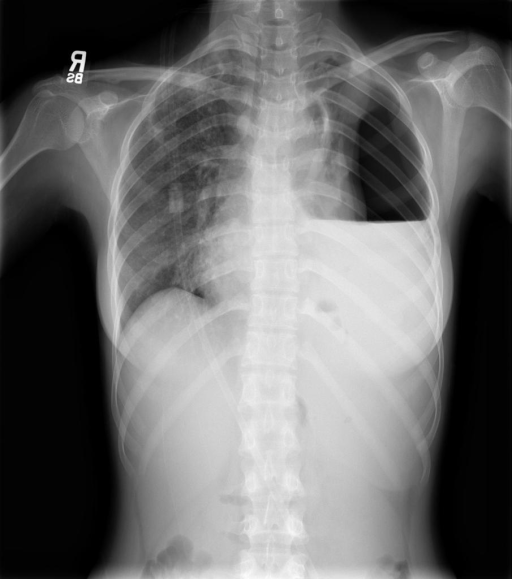

In [25]:
print(f"Index Number: {index}")
image

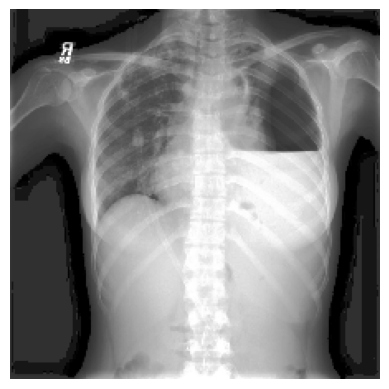

In [26]:
# Convert Image object to numpy array
image = np.array(image)

# # Normalize image
image = image.astype(np.float32) / 255.0

# Histogram equalization
image = cv2.equalizeHist((image * 255).astype(np.uint8)) / 255.0

# Resize image
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(image, cmap="gray")
plt.axis(False)

# Convert image to tensor
image = torch.from_numpy(image).unsqueeze(0).to(torch.float32)

In [27]:
image.shape

torch.Size([1, 224, 224])

In [28]:
model = torch.load(
    "C:/Users/DryLab/Desktop/ViLLA/UNet_Heart.pth",
    map_location=torch.device("cpu"),
)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_27808\2951111469.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(


In [33]:
output = model(image.unsqueeze(0))
output = (output > 0.5).cpu().numpy().squeeze()

In [34]:
output.shape

(224, 224)

In [35]:
lungs_model = torch.load(
    "C:/Users/DryLab/Desktop/ViLLA/UNet_Lungs_Multiclass.pth",
    map_location=torch.device("cpu"),
)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_27808\429336829.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lungs_model = torch.load(


In [36]:
lungs_output = lungs_model(image.unsqueeze(0))
lungs_output = torch.argmax(lungs_output, dim=1).cpu().numpy().squeeze()

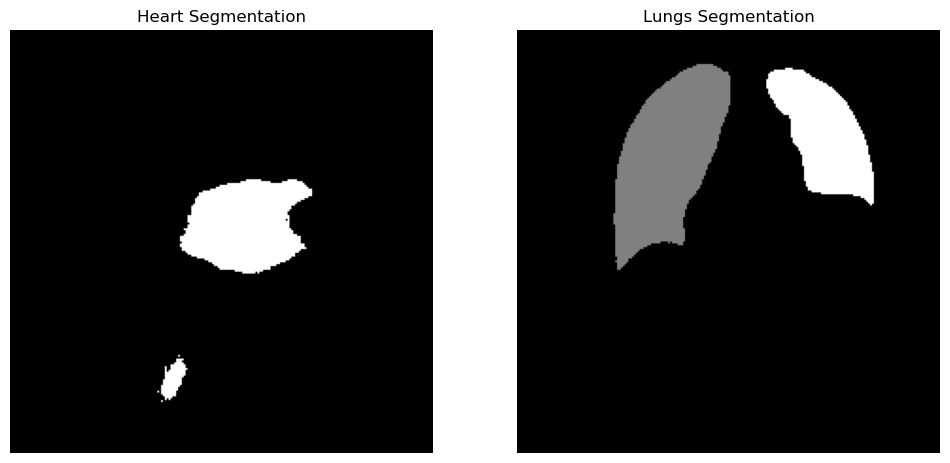

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(output, cmap="gray")
plt.axis(False)
plt.title("Heart Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(lungs_output, cmap="gray")
plt.axis(False)
plt.title("Lungs Segmentation")

plt.show()

In [38]:
right_lung = (lungs_output == 1).astype(np.uint8)
left_lung = (lungs_output == 2).astype(np.uint8)

In [39]:
def postprocess_mask(binary_mask):
    binary_mask = binary_mask.astype(np.uint8)

    # Step 1: Binary opening
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (11, 11)
    )  # Disk-shaped structuring element with radius 5
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Step 2: Keep the largest contiguous segment
    labeled_mask, num_features = label(opened_mask)
    sizes = np.bincount(labeled_mask.ravel())
    sizes[0] = 0  # Exclude background
    largest_segment = np.argmax(sizes)
    largest_mask = np.where(labeled_mask == largest_segment, 1, 0).astype(np.uint8)

    # Step 3: Binary fill holes
    filled_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_CLOSE, kernel)

    # Step 4: Binary dilation
    dilated_mask = cv2.dilate(filled_mask, kernel)

    return dilated_mask

In [40]:
# Postprocess each mask separately
postprocessed_heart = postprocess_mask(output)
postprocessed_right_lungs = postprocess_mask(right_lung)
postprocessed_left_lungs = postprocess_mask(left_lung)

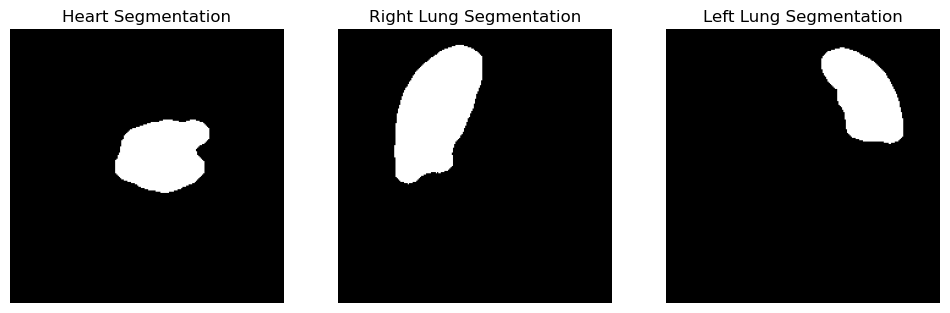

In [41]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(postprocessed_heart, cmap="gray")
plt.axis(False)
plt.title("Heart Segmentation")

plt.subplot(1, 3, 2)
plt.imshow(postprocessed_right_lungs, cmap="gray")
plt.axis(False)
plt.title("Right Lung Segmentation")

plt.subplot(1, 3, 3)
plt.imshow(postprocessed_left_lungs, cmap="gray")
plt.axis(False)
plt.title("Left Lung Segmentation")

plt.show()

In [42]:
def get_bounding_box(region_coords):
    # Find the indices where the region_label exists
    indices = np.nonzero(region_coords)

    # If there are no coordinates for the region_label, return a placeholder
    if len(indices[0]) == 0:
        return np.array([None, None, None, None])  # Placeholder for empty regions

    # Get the min and max x and y coordinates
    min_y, min_x = np.min(indices, axis=1)
    max_y, max_x = np.max(indices, axis=1)

    return np.array([min_x, min_y, max_x, max_y])


heart_bounding_box = get_bounding_box(postprocessed_heart)
right_lungs_bounding_box = get_bounding_box(postprocessed_right_lungs)
left_lungs_bounding_box = get_bounding_box(postprocessed_left_lungs)

In [99]:
indices = np.nonzero(postprocessed_heart)
np.min(indices[1])

86

In [43]:
print(heart_bounding_box)
print(right_lungs_bounding_box)
print(left_lungs_bounding_box)

[ 86  74 162 133]

[ 46  13 117 126]

[127  15 193  93]

4 images. There is a large hydropneumothorax within the left chest. There is essentially complete collapse of the 
left lung. Within the right lung, there are increased interstitial opacities within the medial right lung base and 
right upper lobe, with patchy airspace opacity within the right lung apex. At the right lung apex, there is a more 
focal ovoid lucency which measures approximately 1.3 cm. This could indicate cavitation. Left-sided 
cardiomediastinal contours are obscured by collapse of the left lung. No convincing acute bony findings. 1. Large 
left hydropneumothorax, with complete collapse of the left lung. 2. Airspace and interstitial opacity within the 
right upper and lower lobes. Possible apical cavitation. Tuberculosis should be excluded clinically.

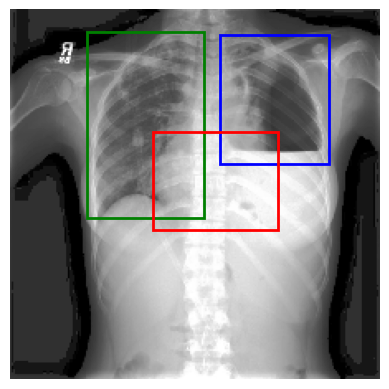

In [111]:
print(text)

# Plot bounding boxes on the image
fig, ax = plt.subplots()

ax.imshow(image.squeeze(), cmap="gray")
ax.axis("off")

# Right Lung Bounding Box
rect = patches.Rectangle(
    (right_lungs_bounding_box[0], right_lungs_bounding_box[1]),
    right_lungs_bounding_box[2] - right_lungs_bounding_box[0],
    right_lungs_bounding_box[3] - right_lungs_bounding_box[1],
    linewidth=2,
    edgecolor="g",
    facecolor="none",
)
ax.add_patch(rect)

rect = patches.Rectangle(
    (left_lungs_bounding_box[0], left_lungs_bounding_box[1]),
    left_lungs_bounding_box[2] - left_lungs_bounding_box[0],
    left_lungs_bounding_box[3] - left_lungs_bounding_box[1],
    linewidth=2,
    edgecolor="b",
    facecolor="none",
)
ax.add_patch(rect)


# Heart Bounding Box
rect = patches.Rectangle(
    (heart_bounding_box[0], heart_bounding_box[1]),
    heart_bounding_box[2] - heart_bounding_box[0],
    heart_bounding_box[3] - heart_bounding_box[1],
    linewidth=2,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

plt.show()

### Get Region Coord for Each Lung Region


In [36]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")

        # Convert Image object to numpy array
        image = np.array(image)

        # Normalize image
        image = image.astype(np.float32) / 255.0

        # Apply histogram equalization
        image = cv2.equalizeHist((image * 255).astype(np.uint8)) / 255.0

        # Resize image
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

        # Convert to tensor and add batch dimension
        image_tensor = torch.from_numpy(image).unsqueeze(0).to(torch.float32)

        return image_tensor

In [38]:
image_paths_list = df["image_filepath"].tolist()

train_dataset = CustomDataset(image_paths_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [39]:
img = next(iter(train_dataloader))

In [40]:
img.shape

torch.Size([32, 1, 224, 224])

In [ ]:
heart_model = torch.load(
    "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/models/UNet_Heart.pth", map_location=device
)

lungs_model = torch.load(
    "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/models/UNet_Lungs_Multiclass.pth", map_location=device
)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_30860\2076272372.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  heart_model = torch.load(
C:\Users\DryLab\AppData\Local\Tem

In [42]:
def lungs_segmentation(model, dataloader, device):
    print(f"Segmenting images using {device}")
    model.eval()
    segmentation_results = []

    with torch.inference_mode():
        for batch, (images) in enumerate(tqdm(dataloader)):
            images = images.to(device)
            model = model.to(device)

            masks = model(images)
            masks = masks.argmax(dim=1).cpu().numpy()

            for i in range(images.shape[0]):
                image_id = batch * dataloader.batch_size + i
                segmentation_results.append((image_id, masks[i]))

    return segmentation_results

In [43]:
def heart_segmentation(model, dataloader, device):
    print(f"Segmenting images using {device}")
    model.eval()
    segmentation_results = []

    with torch.inference_mode():
        for batch, (images) in enumerate(tqdm(dataloader)):
            images = images.to(device)
            model = model.to(device)

            masks = model(images)
            masks = (masks > 0.5).cpu().numpy().squeeze()

            for i in range(images.shape[0]):
                image_id = batch * dataloader.batch_size + i
                segmentation_results.append((image_id, masks[i]))

    return segmentation_results

In [79]:
lungs_mask = lungs_segmentation(lungs_model, train_dataloader, device)

Segmenting images using cuda

100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


In [80]:
heart_mask = heart_segmentation(heart_model, train_dataloader, device)

Segmenting images using cuda

100%|██████████| 119/119 [00:27<00:00,  4.31it/s]


Text(0.5, 1.0, 'Heart Segmentation')

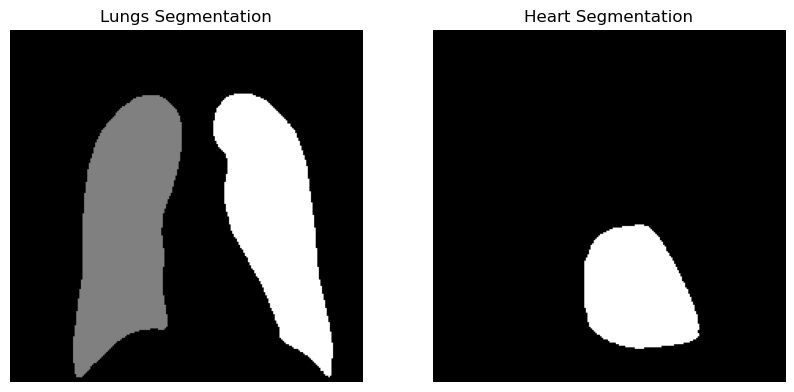

In [81]:
index = random.randint(0, len(df) - 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(lungs_mask[index][1], cmap="gray")
plt.axis(False)
plt.title("Lungs Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(heart_mask[index][1], cmap="gray")
plt.axis(False)
plt.title("Heart Segmentation")

In [82]:
right_lung = (lungs_mask[index][1] == 1).astype(np.uint8)
left_lung = (lungs_mask[index][1] == 2).astype(np.uint8)

## Post-Processing

In [83]:
# Assuming lungs_mask contains (batch, mask) pairs
for idx, (batch, mask) in enumerate(tqdm(lungs_mask)):
    # Define left and right lungs
    right_lung = (mask == 1).astype(np.uint8)
    left_lung = (mask == 2).astype(np.uint8)
    
    # Apply the existing postprocess_mask function
    postprocessed_right_lung = postprocess_mask(right_lung)
    postprocessed_left_lung = postprocess_mask(left_lung)
    
    # Combine the postprocessed masks back into one output
    postprocessed_mask = np.zeros_like(mask)
    postprocessed_mask[postprocessed_right_lung == 1] = 1
    postprocessed_mask[postprocessed_left_lung == 1] = 2
    
    # Update the mask in place
    lungs_mask[idx] = (batch, postprocessed_mask)

100%|██████████| 3795/3795 [00:04<00:00, 881.49it/s]


In [84]:
# Assuming lungs_mask contains (batch, mask) pairs
for idx, (batch, mask) in enumerate(tqdm(heart_mask)):
    # Apply the existing postprocess_mask function
    postprocessed_mask = postprocess_mask(mask)
    
    # Update the mask in place
    heart_mask[idx] = (batch, postprocessed_mask)

100%|██████████| 3795/3795 [00:02<00:00, 1831.04it/s]


Text(0.5, 1.0, 'Heart Segmentation')

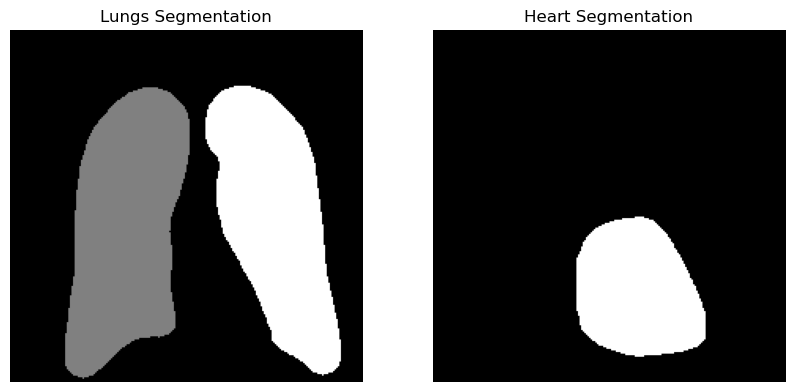

In [85]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(lungs_mask[index][1], cmap="gray")
plt.axis(False)
plt.title("Lungs Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(heart_mask[index][1], cmap="gray")
plt.axis(False)
plt.title("Heart Segmentation")

In [86]:
batch, mask = lungs_mask[0]
batch, mask.shape

(0, (224, 224))

In [87]:
df["image_size"] = [list(mask.shape) for _, mask in lungs_mask]
df

,image_id,image_filepath,text_filepath,image_size,region_coord,num_regions
0,0,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
1,1,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
2,2,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3,3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
4,4,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
...,...,...,...,...,...,...
3790,3790,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3791,3791,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3792,3792,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3793,3793,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3


In [88]:
index = random.randint(0, len(df))

batch, mask = heart_mask[index]

# Check min and max values
print(f"Min Value: {mask.min()}")
print(f"Max Value: {mask.max()}")

right_lung_mask = torch.from_numpy(mask) == 1
right_lung_mask.shape

Min Value: 0

Max Value: 1

torch.Size([224, 224])

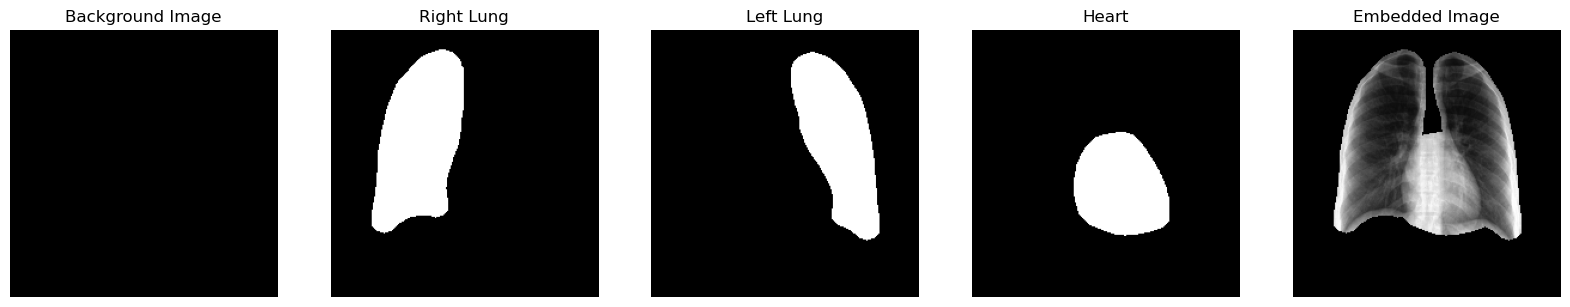

In [89]:
# Plot left lung, right lung, and heart coordinates for the first image
plt.figure(figsize=(20, 5))

index = random.randint(0, len(df))

plt.subplot(1, 5, 1)
plt.title("Background Image")
plt.imshow(lungs_mask[index][1] == 3, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 2)
plt.title("Right Lung")
plt.imshow(lungs_mask[index][1] == 1, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 3)
plt.title("Left Lung")
plt.imshow(lungs_mask[index][1] == 2, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 4)
plt.title("Heart")
plt.imshow(heart_mask[index][1] == 1, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 5)
plt.title("Embedded Image")
combined_mask = np.logical_or.reduce([
    lungs_mask[index][1] == 1,  # Right lung
    lungs_mask[index][1] == 2,  # Left lung
    heart_mask[index][1] == 1   # Heart
])
plt.imshow(train_dataset[index].squeeze() * combined_mask, cmap="gray")
plt.axis(False)


plt.show()

## Combined Lungs and Heart Region

In [90]:
full_mask = []

for idx, (batch, masks) in enumerate(tqdm(lungs_mask)):
    # Create separate masks for right lung, left lung, and heart
    right_lung = (masks == 1).astype(np.uint8)
    left_lung = (masks == 2).astype(np.uint8)
    heart = (heart_mask[idx][1] == 1).astype(np.uint8)
    
    # Initialize combined_mask with zeros
    combined_mask = np.zeros_like(masks, dtype=np.uint8)
    
    # Assign distinct values to each region
    combined_mask[right_lung == 1] = 1  # Right Lung
    combined_mask[left_lung == 1] = 2  # Left Lung
    combined_mask[heart == 1] = 3      # Heart
    
    combined_mask = combined_mask.astype(np.uint8)
    
    # Append the batch and the combined mask to full_mask
    full_mask.append((batch, combined_mask))


100%|██████████| 3795/3795 [00:00<00:00, 5864.12it/s]


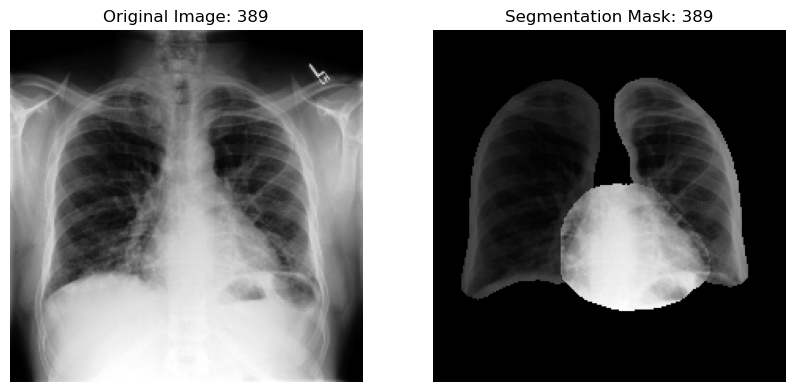

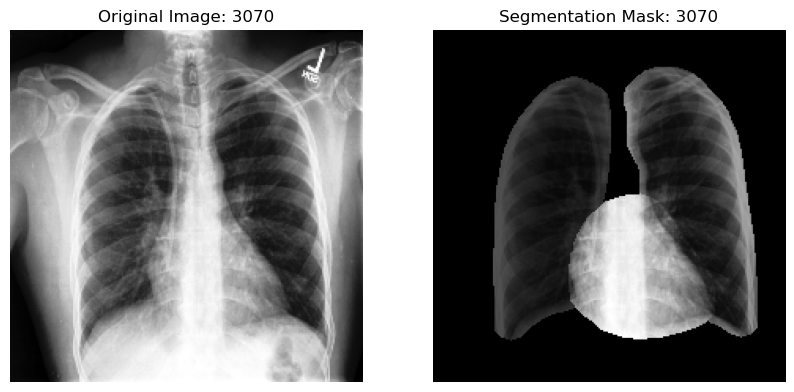

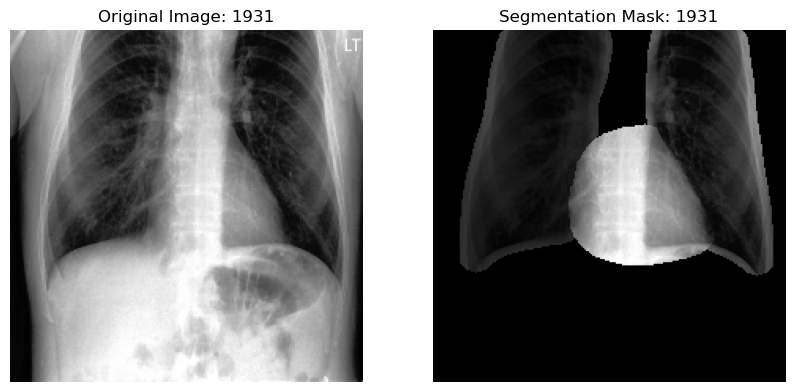

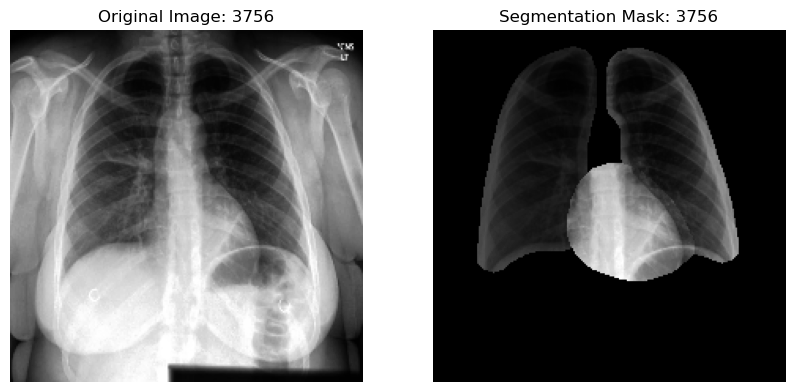

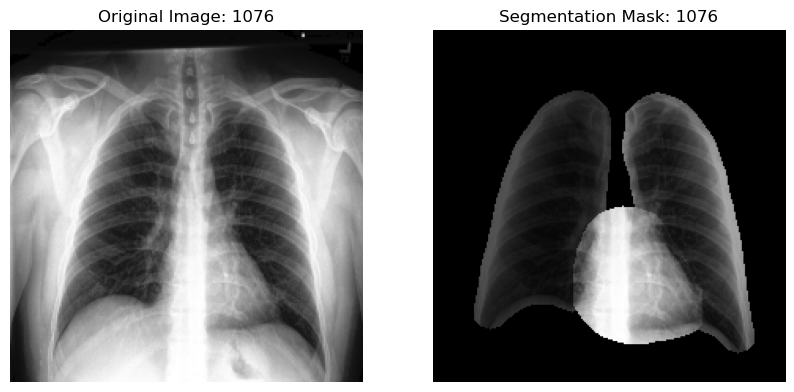

In [91]:
def visualize_segmentation_results(segmentation_results, dataset, num_samples=5):
    # Randomly sample a few segmentation results
    sample_results = random.sample(segmentation_results, num_samples)

    for index, mask in sample_results:
        # Load the corresponding image from the dataset
        original_image = (
            dataset[index][0].cpu().numpy()
        )  # Assuming the dataset returns (C, H, W)

        # Plot the original image and the segmentation mask
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f"Original Image: {index}")
        plt.imshow(original_image.squeeze(), cmap="gray")
        plt.axis(False)

        plt.subplot(1, 2, 2)
        plt.title(f"Segmentation Mask: {index}")
        plt.imshow(original_image * mask, cmap="gray")
        plt.axis(False)

        plt.show()


visualize_segmentation_results(full_mask, train_dataset, num_samples=5)

(-0.5, 223.5, 223.5, -0.5)

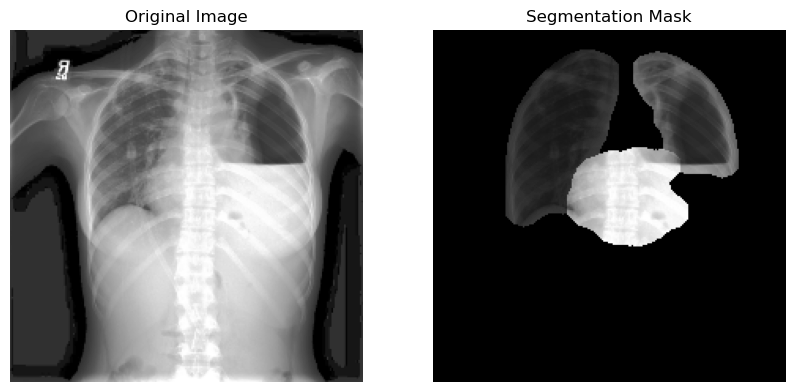

In [92]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(train_dataset[554].squeeze(), cmap="gray")
plt.title("Original Image")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(train_dataset[554].squeeze() * full_mask[554][1], cmap="gray")
plt.title("Segmentation Mask")
plt.axis(False)

In [93]:
# Initialize a NumPy array to store reg_coords for all images
all_reg_coords = np.empty(len(full_mask), dtype=object)

for i in range(len(full_mask)):
    batch, mask = full_mask[i]

    # Convert mask to torch tensor for processing
    mask_tensor = torch.from_numpy(mask)

    # Create boolean masks for each organ
    right_lung_mask = mask_tensor == 1
    left_lung_mask = mask_tensor == 2
    heart_mask = mask_tensor == 3

    # Combine the coordinates into an array of arrays
    reg_coords = [
        np.array(right_lung_mask.cpu().numpy().astype(np.uint64).reshape(-1)),
        np.array(left_lung_mask.cpu().numpy().astype(np.uint64).reshape(-1)),
        np.array(heart_mask.cpu().numpy().astype(np.uint64).reshape(-1)),
    ]

    # Initialize a NumPy array to store the reg_coords for this image
    reg_coords_array = np.empty(3, dtype=object)

    # Store each organ's coordinates in the reg_coords_array
    for j in range(3):
        reg_coords_array[j] = reg_coords[j]

    # Append to the main NumPy array
    all_reg_coords[i] = reg_coords_array

In [94]:
# Check if all images has masks
len(all_reg_coords) == len(df)

True

In [95]:
all_reg_coords.shape

(3795,)

In [96]:
all_reg_coords[0].shape

(3,)

In [97]:
# Add DataFrame Column with the coordinates of the masks
df["region_coord"] = all_reg_coords

In [98]:
df["region_coord"].iloc[0].shape

(3,)

In [99]:
df["num_regions"] = df["region_coord"].apply(lambda x: len(x))

In [100]:
df

,image_id,image_filepath,text_filepath,image_size,region_coord,num_regions
0,0,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
1,1,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
2,2,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3,3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
4,4,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
...,...,...,...,...,...,...
3790,3790,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3791,3791,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3792,3792,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3793,3793,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3


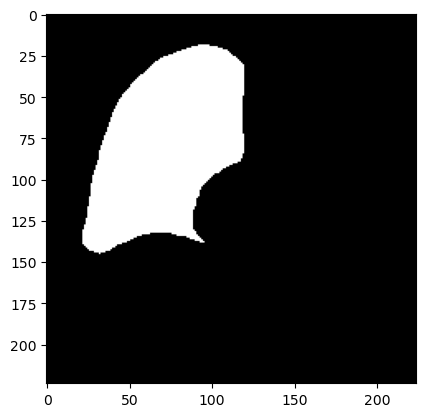

In [103]:
plt.imshow(df['region_coord'].iloc[0][0].reshape(224, 224), cmap='gray')

In [104]:
def get_bounding_box(region_coords):
    # Find the indices where the region_label exists
    indices = np.nonzero(region_coords)

    # If there are no coordinates for the region_label, return a placeholder
    if len(indices[0]) == 0:
        return np.array([None, None, None, None])  # Placeholder for empty regions

    # Get the min and max x and y coordinates
    min_y, min_x = np.min(indices, axis=1)
    max_y, max_x = np.max(indices, axis=1)

    return np.array([min_x, min_y, max_x, max_y])


def process_row(region_coords, original_shape):
    # Reshape the region_coords to the original shape
    right_lung_coords = region_coords[0]  # Right Lung
    left_lung_coords = region_coords[1]  # Left Lung
    heart_coords = region_coords[2]  # Heart

    right_lung_2d = right_lung_coords.reshape(original_shape)
    left_lung_2d = left_lung_coords.reshape(original_shape)
    heart_2d = heart_coords.reshape(original_shape)

    # Calculate the bounding box for each region
    left_lung_bbox = get_bounding_box(right_lung_2d)
    right_lung_bbox = get_bounding_box(left_lung_2d)
    heart_bbox = get_bounding_box(heart_2d)

    # Concatenate all bounding boxes into a single 1D array
    region_bbox = [
        np.array(right_lung_bbox.reshape(-1)),
        np.array(left_lung_bbox.reshape(-1)),
        np.array(heart_bbox.reshape(-1)),
    ]

    # Initialize a NumPy array to store the reg_coords for this image
    reg_bbox_array = np.empty(3, dtype=object)

    # Store each organ's coordinates in the reg_coords_array
    for j in range(3):
        reg_bbox_array[j] = region_bbox[j]

    return reg_bbox_array


# Assuming `all_reg_coords` is already populated as in your previous example
# and `original_shape` is known for each image

# Initialize a NumPy array to store region_bbox for all images
all_region_bbox = np.empty(len(all_reg_coords), dtype=object)

for i in range(len(all_reg_coords)):
    region_coords = all_reg_coords[i]

    # Assuming original_shape is known and is the same for all images
    # Replace `original_shape` with the actual shape of the mask
    original_shape = (224, 224)  # Replace with actual dimensions

    # Process each row to compute bounding boxes
    region_bbox = process_row(region_coords, original_shape)

    # Store the result in the NumPy array
    all_region_bbox[i] = region_bbox

In [105]:
# Apply function to each row
df["region_bbox"] = df["region_coord"].apply(lambda x: process_row(x, original_shape))

In [106]:
df["region_coord"].iloc[0]

array([array([0, 0, 0, ..., 0, 0, 0], dtype=uint64),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint64),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)], dtype=object)

In [107]:
df["region_bbox"].iloc[0]

array([array([136,  19, 223, 143], dtype=int64),
       array([ 22,  19, 119, 145], dtype=int64),
       array([ 89,  88, 196, 155], dtype=int64)], dtype=object)

In [108]:
df["region_bbox"].iloc[0].shape

(3,)

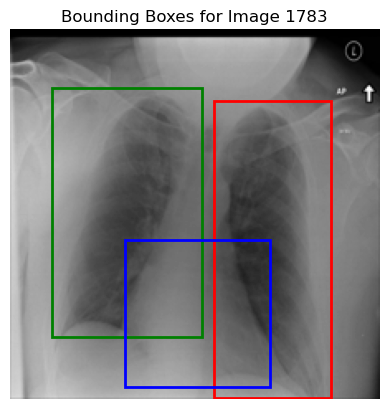

In [123]:
index = random.randint(0, len(df))


def plot_bounding_boxes_for_index(
    df, index, image_column="image_filepath", bbox_column="region_bbox"
):
    # Load the image using the index
    image_path = df[image_column].iloc[index]
    image = Image.open(image_path).convert("L")
    image = image.resize((224, 224))

    # Extract the bounding boxes
    bounding_boxes = df[bbox_column].iloc[index]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")

    # Unpack the bounding boxes
    left_lung_bbox = bounding_boxes[0]
    right_lung_bbox = bounding_boxes[1]
    heart_bbox = bounding_boxes[2]

    # Define bounding boxes' colors
    colors = ["r", "g", "b"]  # Red for right lung, Green for left lung, Blue for heart

    # Create rectangles for each bounding box and add them to the plot
    for bbox, color in zip([left_lung_bbox, right_lung_bbox, heart_bbox], colors):
        if not np.array_equal(
            bbox, [0, 0, 0, 0]
        ):  # Skip if the bbox is just a placeholder
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    # Hide axis and show the plot
    plt.title(f"Bounding Boxes for Image {index}")
    plt.axis(False)
    plt.show()


# Example usage
plot_bounding_boxes_for_index(df, index)

In [124]:
df["region_labels"] = [np.array([1, 2, 3]) for _ in range(len(df))]

df["region_labels"] = df["region_labels"].apply(lambda labels: [labels])

# Initialize an empty NumPy array to store the transformed region labels
transformed_labels = np.empty(len(df), dtype=object)

# Process each row in the DataFrame
for i in range(len(df)):
    # Extract the nested array
    nested_array = df["region_labels"].iloc[i][0]

    # Initialize an empty NumPy array to store the transformed labels
    labels_array = np.empty(len(nested_array), dtype=object)

    # Convert each label to its own NumPy array and store it
    for j, label in enumerate(nested_array):
        labels_array[j] = np.array([label], dtype=np.uint64)

    # Store the transformed labels array in the main array
    transformed_labels[i] = labels_array

# Update the DataFrame with the transformed labels
df["region_labels"] = transformed_labels

In [125]:
# Rearrange df Image-Text columns for better visualization

df = df[
    [
        "image_id",
        "image_size",
        "image_filepath",
        "region_coord",
        "region_bbox",
        "region_labels",
        "num_regions",
        "text_filepath",
    ]
]

In [126]:
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[136, 19, 223, 143], [22, 19, 119, 145], [89,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[117, 17, 219, 167], [0, 16, 99, 161], [69, 8...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[122, 42, 200, 177], [45, 43, 109, 175], [83,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[115, 12, 194, 194], [35, 13, 109, 192], [87,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[108, 32, 200, 173], [5, 34, 96, 177], [71, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
...,...,...,...,...,...,...,...,...
3790,3790,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[128, 14, 204, 175], [33, 11, 121, 174], [90,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3791,3791,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[119, 7, 200, 222], [22, 8, 111, 210], [88, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3792,3792,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[116, 0, 196, 166], [22, 0, 107, 156], [87, 4...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3793,3793,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[122, 15, 197, 168], [37, 14, 116, 160], [98,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...


In [127]:
df.to_feather(f"{DATA_DIR}/annotations_region_final.feather")